In [1]:
from model import PolicyModel, Policy
from GAE import collect_trajectory, GAE
from PPO import PPO
import torch


In [2]:
import gymnasium as gym
class MountainCarPotentialWrapper(gym.Wrapper):
    def __init__(self, env, gamma=0.99, coefficient=1.0):
        super().__init__(env)
        self.gamma = gamma
        self.coefficient = coefficient
        self.last_state = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_state = obs.copy()
        return obs, info

    def step(self, action):
        new_state, reward, terminated, truncated, info = self.env.step(action)

        modified_reward = reward
        if self.last_state is not None:
            shaping = self.coefficient * (
                self.gamma * abs(new_state[1]) - abs(self.last_state[1])
            )

            modified_reward += shaping

        self.last_state = None if terminated or truncated else new_state.copy()

        return new_state, modified_reward, terminated, truncated, info

In [3]:
import numpy as np
import gymnasium as gym 

In [4]:
def make_env():
    # environment
    env_id = "MountainCar-v0"
    env = gym.make(env_id)
    return env

In [5]:
env = make_env()
# wrapped_env = MountainCarPotentialWrapper(env)
wrapped_env = MountainCarPotentialWrapper(env, gamma = 1.3424353702937695, coefficient=300.33740906168394)
state_dim = env.observation_space.shape[0]
action_dim = wrapped_env.action_space.n

print(state_dim, action_dim)

model = PolicyModel(state_dim, action_dim).cpu()
policy = Policy(model)
gae = GAE(policy)

2 3


In [6]:
optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, weight_decay=1e-5)
n_iter = 2000
lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = PPO(policy, optimizer, value_loss_coef=0.5)


In [7]:
result = env.reset()
print("Type:", type(result))
print("Content:", result)
print("Length:", len(result) if hasattr(result, '__len__') else "Not a list")

Type: <class 'tuple'>
Content: (array([-0.5331497,  0.       ], dtype=float32), {})
Length: 2


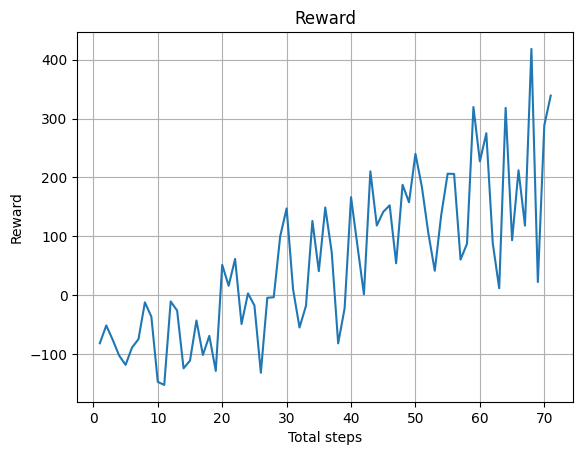

 29%|██▊       | 7185/25000 [13:29<33:27,  8.87it/s]


KeyboardInterrupt: 

In [8]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tqdm import tqdm

steps = []
rewards = []
n_iter = 25_000
counter = 0

for i in tqdm(range(n_iter)):
    trajectory = gae(collect_trajectory(wrapped_env, policy, 200))
    

    if (i + 1) % 100 == 0:
        clear_output(True)
        mean_reward = np.sum(trajectory["rewards"])   # или .sum()
        rewards.append(mean_reward)
        steps = list(range(1,len(rewards)+1))

        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()
    if counter == 5:
        print("Обучение закончено")
        break
    ppo.step(trajectory)
    sched.step()
    

In [14]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import os

def evaluate_with_video(env_id, actor, save_path="videos", n_games=1, t_max=1000):
    """
    Plays n_games and returns rewards while saving videos of the episodes.
    """
    os.makedirs(save_path, exist_ok=True)

    # создаем окружение с возможностью рендера и записи видео
    env = gym.make(env_id, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=save_path, name_prefix="eval")

    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()
        R = 0
        for _ in range(t_max):
            action_dict = actor.act(np.array([s]), training=False)
            action = action_dict["actions"]

            if action.ndim == 2 and action.shape[0] == 1:
                action = action[0]

            s, r, terminated, truncated, _ = env.step(action.item())
            R += r

            if terminated or truncated:
                break

        rewards.append(R)

    env.close()
    print(f"Видео сохранено в папке {os.path.abspath(save_path)}")
    return np.array(rewards)


In [15]:
results = evaluate_with_video("MountainCar-v0", policy, save_path="videos", n_games=2, t_max=1000)
print(results)

/home/dima/Documents/prepare_for_s/venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/dima/Documents/prepare_for_s/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Видео сохранено в папке /home/dima/Documents/prepare_for_s/videos
[-200. -173.]


In [16]:
from pathlib import Path

video_dir = Path("videos")
if not video_dir.exists():
    print(f"Директория {video_dir} не существует!")
else:
    print(f"Файлы в {video_dir}:")
    for f in video_dir.iterdir():
        print(f" - {f.name}")

Файлы в videos:
 - eval-episode-1.mp4
 - eval-episode-0.mp4


In [18]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [11]:
from moviepy import VideoFileClip

def video_to_gif(video_path, gif_path, start_time=None, end_time=None, fps=15):
    """
    Конвертирует видео в GIF.

    video_path: str — путь к видеофайлу
    gif_path: str — куда сохранить GIF
    start_time, end_time: float — опционально, для обрезки видео в секундах
    fps: int — частота кадров для GIF
    """
    clip = VideoFileClip(video_path)

    if start_time is not None or end_time is not None:
        clip = clip.subclip(start_time or 0, end_time or clip.duration)

    clip.write_gif(gif_path, fps=fps)
    print(f"GIF сохранен в {gif_path}")


In [13]:
video_to_gif("videos/eval-episode-1.mp4", "episode_0.gif", fps=20)

MoviePy - Building file episode_0.gif with imageio.


GIF сохранен в episode_0.gif


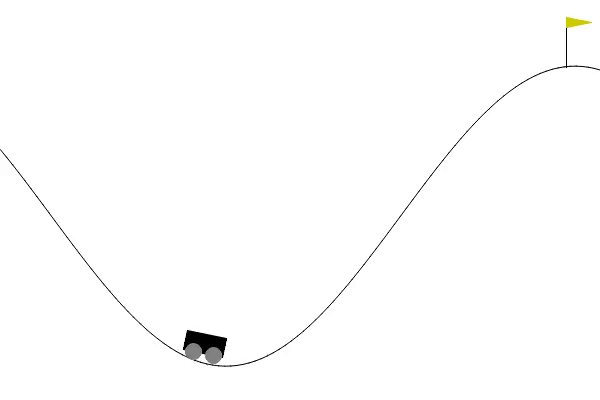

In [14]:
from IPython.display import Image

# Просто вставляем путь к GIF
Image(filename="episode_0.gif")